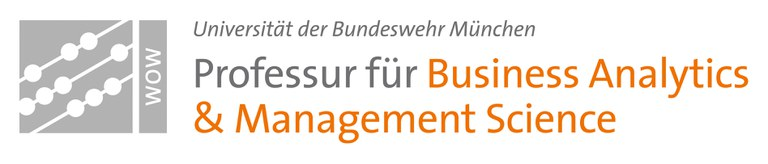

# Traveling Salesman Problem - Zufällige Instanz - PuLP
### Universität der Bundeswehr München - Prof. Dr. Claudius Steinhardt - Logistics Analytics

#### Universität der Bundeswehr München - Prof. Dr. Claudius Steinhardt - Logistics Analytics
Erstellt von Sebastian Knall am 30.03.2022

#### Das vorliegene Notebook generiert eine zufällige TSP Instanz. Die Instanz wird mit dem Open Source Solver PuLP (https://pypi.org/project/PuLP/) gelöst.
#### Als Anwendungsfall wird hier eine 'Kneipentour' gewählt. Start und Ziel der Tour ist die UniBw.

In [2]:
# Importieren der Bibliotheken
import ipywidgets as widgets
import itertools
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pulp
from pulp import *
from scipy.spatial import distance_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Anzahl Kneipen auswählen:

In [3]:
# Benutzereingabe Anzahl zu besuchender Kneipen
# Variable 'kneipen' durch einen Slider festlegen, der nur Integer zulässt
kneipen = widgets.IntSlider(
    value=7,                                    # Voreingestellter Wert falls kein Wert ausgewählt
    min=0,                                      # Kleinster einstellbarer Wert
    max=15,                                     # Größter einstellbarer Wert
    step=1,                                     # Stufen zwischen den eistellbaren Werten
    description='Kneipen:',                     # Angezeigter Name des Sliders
    disabled=False,                             # Ist der Slider deaktiviert
    continuous_update=False,                    # Ändert sich der Wert nachdem die nächste Zelle ausgeführt wurde
    orientation='horizontal',                   # Darstellung des Sliders
    readout=True,                               # Wird der gewählte Wert angezeigt
    readout_format='d',                         # Format des Wertes ('d' - Ganzzahlig, '.1f' - eine Nachkommestelle)
)
display(kneipen)

IntSlider(value=7, continuous_update=False, description='Bars:', max=15)

In [23]:
# Definieren TSP

# Anzahl Kneipenstandorte (Kneipen + Start)
n = kneipen.value + 1

# Erstellen eines DataFrames mit zufällig generierten Koordinaten

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n),
    'y': np.random.randint(0, 100, n),
})

# Erstellen eines DataFrames mit zufällig generierten Koordinaten
df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0

# Ausgabe DataFrame
print(df)

    x   y
0   0   0
1  80  19
2  17  67


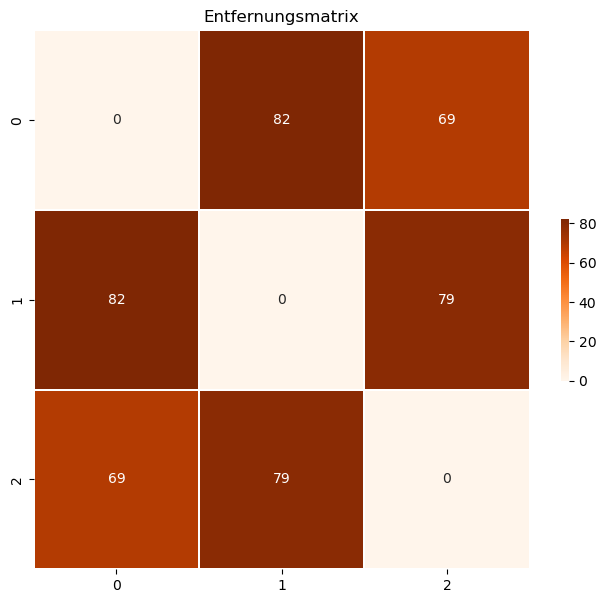

In [24]:
#  Erstellen Entfernungsmatrix aus Koordinaten
entfernungen = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

# Darstellung Entfernungsmaxtrix als Heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(entfernungen, ax=ax, cmap='Oranges', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('Entfernungsmatrix')
plt.show()

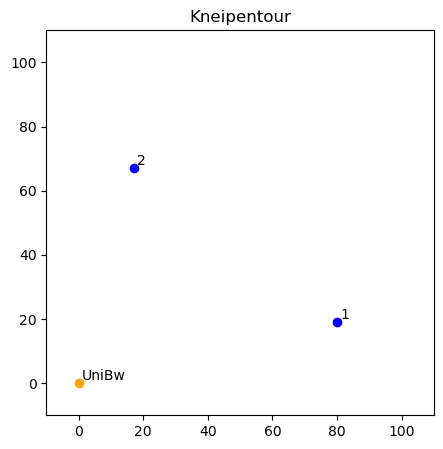

In [25]:
# Graphische Darstellung der TSP Instanz
plt.figure(figsize=(5, 5))

for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='orange')
        plt.text(row['x'] + 1, row['y'] + 1, 'UniBw')
    else:
        plt.scatter(row['x'], row['y'], c='blue')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('Kneipentour')
plt.show()

In [26]:
# Initialisieren eines neuen PuLP-Modells als Minimierungsproblem
prob = LpProblem("TSP", LpMinimize)

In [27]:
# Initialisierung der Variablen
# Variablen könnten durch vier Parameter spezifiziert werden: Name, untere Grenze, obere Grenze und Typ (ganzzahlig, kontinuierlich, binär)
# Sind keine Parameter angegeben, werden Standardwerte verwendet
# Bei binären Variablen ist keine Angabe der Grenzen erforderlich
x = LpVariable.dicts('x', ((i, j) for i in range(n) for j in range(n)), lowBound=0, upBound=1, cat='Binary')

# 'Miller-Tucker-Zemlim' Formululierung zur Vermeidung von Kurzzyklen - Siehe unten
# Die Variable u erhält ihren Wert in aufsteigender Reihenfolge der besuchten Ziele. Wird zunächst i besucht und dann j so muss uj > ui
u = LpVariable.dicts('u', (i for i in range(n)), lowBound=1, upBound=n, cat='Integer')

# Für eine alternative Formulierung der Nebenbedingungen mit nur einer Entscheidungsvarible siehe
# 'Traveling Salesman Problem - Beispielinstanz Vorlesung - PuLP' 

In [28]:
# Zielfunktion
prob += lpSum(entfernungen[i][j] * x[i, j] for i in range(n) for j in range(n))

In [29]:
# # Nebenbedingungen, die sicherstellen, dass jeder Knoten von sich selbst 0 entfernt ist
for i in range(n):
    prob += x[i, i] == 0

# Nebenbedingungen, die sicherstellen, dass jeder Standort genau einmal besucht wird
for i in range(n):
    prob += lpSum(x[i, j] for j in range(n)) == 1
    prob += lpSum(x[j, i] for j in range(n)) == 1

In [30]:
# Nebenbedingungen, die sicherstellen, dass Kurzzyklen vermieden werden
# z.B. ist x[i, j] = 1 so folgt, dass uj = ui + 1; dies führt dazu, dass alle Knoten in Reihenfolge besucht werden
for i in range(n):
    for j in range(n):
        if i != j and (i != 0 and j != 0):
            prob += u[i] - u[j] <= n * (1 - x[i, j]) - 1
            
# Für eine alternative Nebenbedingung mit nur einer Entscheidungsvarible siehe
# 'Traveling Salesman Problem - Einzelne Instanz - PuLP'

In [31]:
# Lösen des Modells
prob.solve()

1

In [32]:
# Ausgeben des Status
print("Status:", LpStatus[prob.status])

Status: Optimal


In [33]:
# Ausgeben Mindestentfernung
print("Mindestentfernung: ", value(prob.objective))

Mindestentfernung:  230.55065157249322


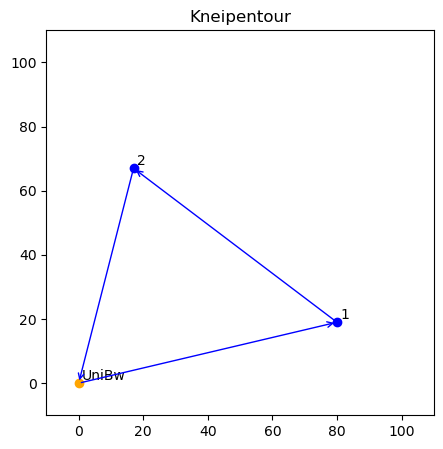

In [34]:
# Darstellung TSP graphisch

plt.figure(figsize=(5, 5))

# Problem darstellen
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='orange')
        plt.text(row['x'] + 1, row['y'] + 1, 'UniBw')
        
    else:
        plt.scatter(row['x'], row['y'], c='blue')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('Kneipentour')

# Optimale Route zeichnen
routes = [(i, j) for i in range(n) for j in range(n) if pulp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)

# Lösung anzeigen
plt.show()